# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os

from imageio import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

import datetime
#from scipy.misc.pilutil import imread, imresize
import math
import os
from keras.models import Sequential, Model
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, ConvLSTM2D,ConvLSTM3D,GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, Dense, TimeDistributed, LSTM, GRU, Bidirectional, SimpleRNN, RNN

from keras import optimizers
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam,SGD
#from keras.layers.convolutional import Conv2D, MaxPooling3D, Conv3D, MaxPooling2D
#from keras.layers.recurrent import GRU
from keras.layers import Activation, Dropout, ZeroPadding3D
#from keras.layers.recurrent import LSTM

from keras.layers import Conv3D, MaxPooling3D, Conv2D
#from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [22]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
batch_size = 30
train_doc = np.random.permutation(open('Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/Project_data/val.csv').readlines())
training_folder = 'Project_data/Project_data/train'
testing_folder = 'Project_data/Project_data/test'

image_sequeneces = range(1,30,2)
image_length = 64
image_breadth = 64

input_shape = (len(image_sequeneces), image_length, image_breadth, 3)


#train_doc.shape
# for n in image_sequeneces:
#     print (n)

Visualizing an Image

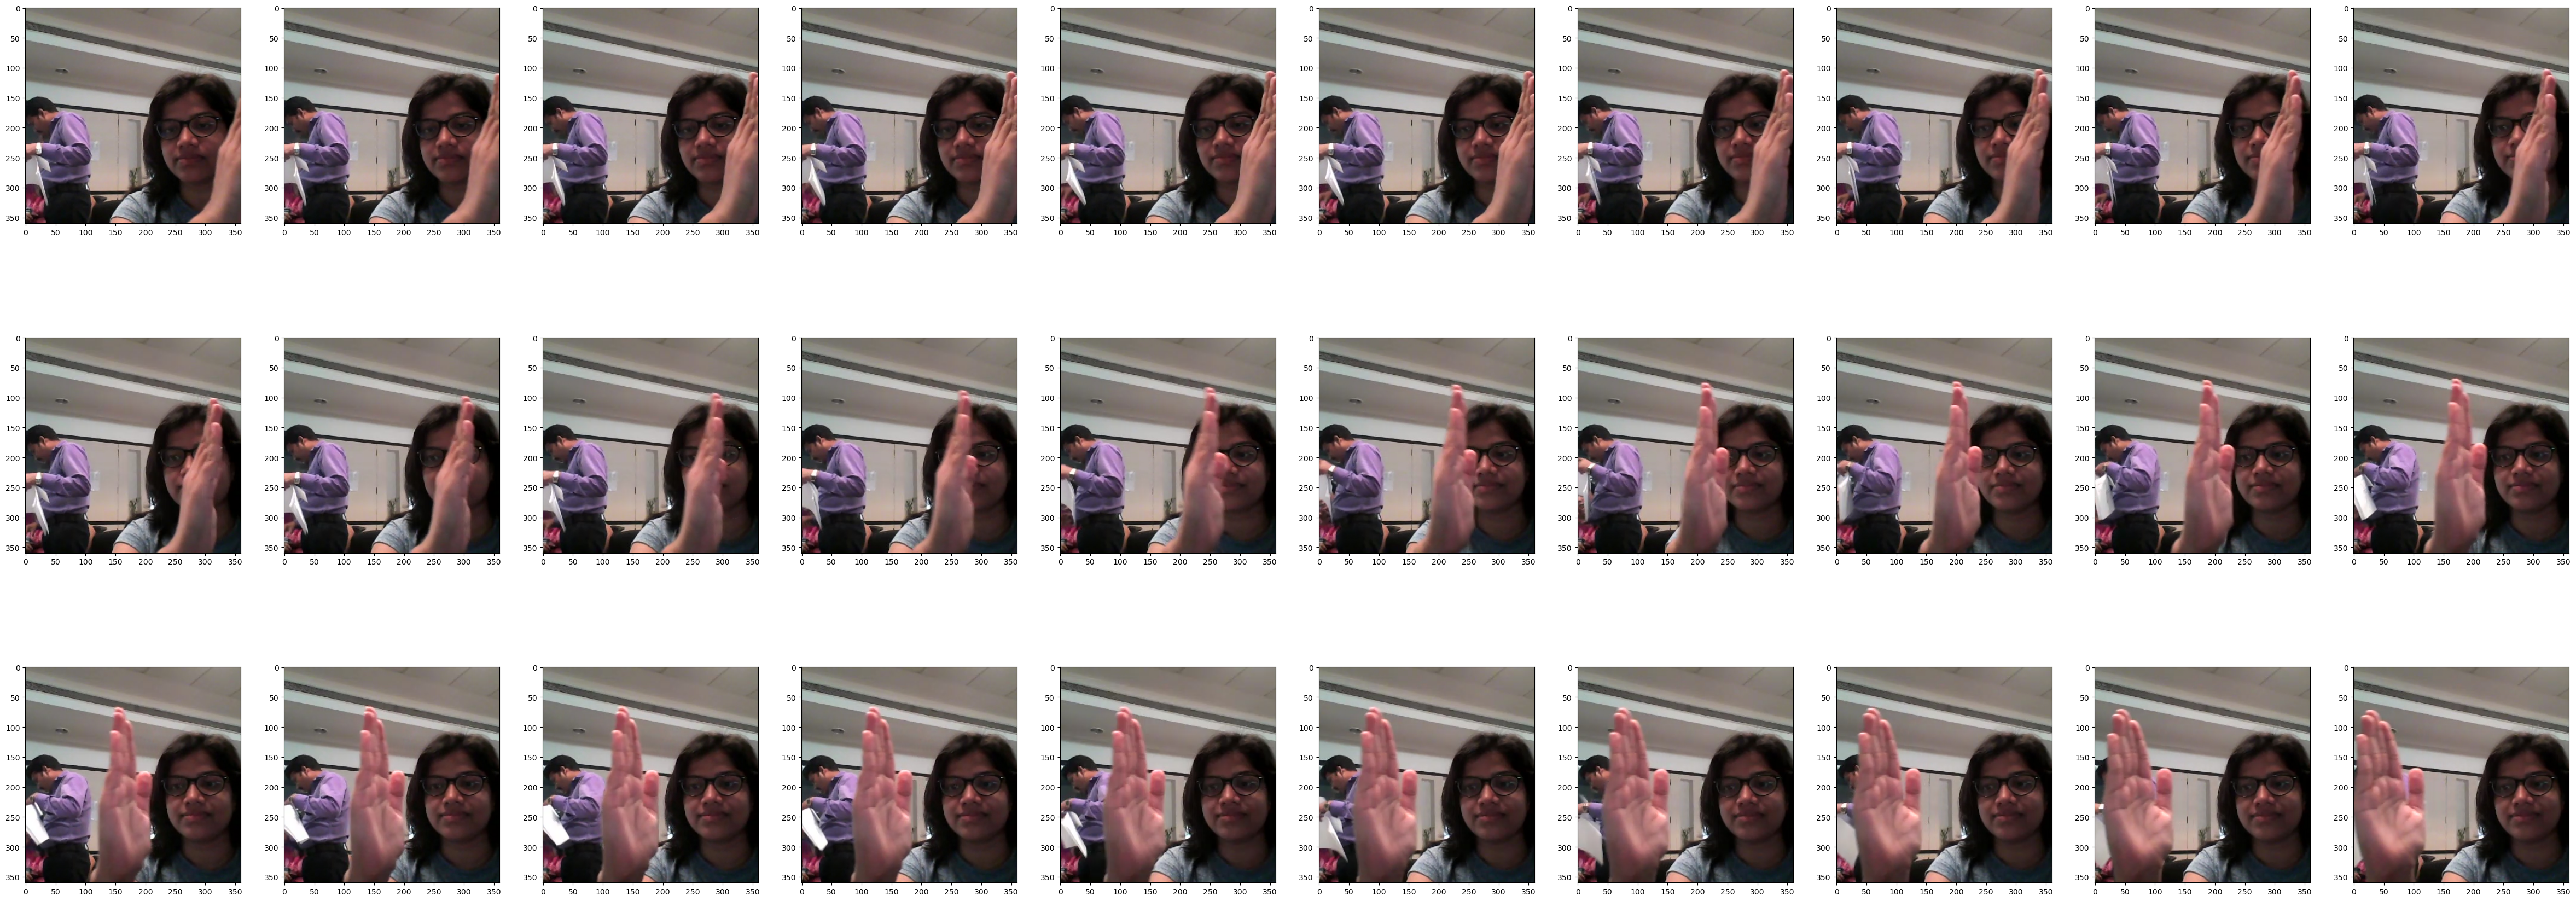

In [4]:
%matplotlib inline

images = []
for img_path in glob.glob('Project_data/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/*.png'):
    images.append(mpimg.imread(img_path))
       
plt.figure(figsize=(60,30))
columns = 10
for i, image in enumerate(images):
    plt.subplot(math.floor(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:

def generator(source_path, folder_list, batch_size, is_train = False, augmention = False, debug=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size, is_train = False, augmention = False, debug=False)
    img_idx = image_sequeneces
    x = len(img_idx)
    y = image_length
    z = image_breadth
#     print ("came here")
    while True:
        t = np.random.permutation(folder_list)
        
        last_batch = 0

        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
            last_batch = 0
        else:
            last_batch = len(t) - (math.floor(len(t)/batch_size) * batch_size)
            num_batches = len(t)//batch_size + 1
            

#         print ("came here num_batches: " + str(num_batches))
#         print ("came here num_batches: " + str(last_batch))


        for batch in range(num_batches): # we iterate over the number of batches
#             print ("Inside For")
            
            processing_batch_size = batch_size
            if (batch==num_batches-1) and (last_batch>0):
#                 print ("passing last batch")
                processing_batch_size = last_batch
#             else:
# #                 print ("not last batch")
            
            batch_data = np.zeros((processing_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((processing_batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(processing_batch_size): # iterate over the batch_size

                imgs = os.listdir(source_path+'/'+ t[folder + (batch*processing_batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*processing_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    if image.shape[1] != image.shape[0]:
                        diff_shape = abs(image.shape[1] - image.shape[0])
                        crop_start = diff_shape // 2
                        crop_end = crop_start + min(image.shape[0],image.shape[1])
                        if image.shape[1] > image.shape[0]:
                            image = image[:, crop_start:crop_end]
                        else:
                            image = image[crop_start:crop_end, :]
                            
                    resized_image = resize(image, output_shape=(y,z))
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = resized_image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*processing_batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
train_path = 'Project_data/Project_data/train'
val_path = 'Project_data/Project_data/val'
#Project_data/Project_data
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model1 with Conv3D and MaxPooling3D
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:


#write your model here
Model1 = Sequential()
Model1.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
Model1.add(MaxPooling3D(pool_size=2))

Model1.add(Conv3D(64, kernel_size=3, activation='relu'))
Model1.add(MaxPooling3D(pool_size=2))

Model1.add(Flatten())
Model1.add(Dense(256, activation='relu'))
Model1.add(Dense(5, activation='softmax'))



C:\Users\mathu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser = optimizers.Adam(learning_rate=0.01)

Model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (Model1.summary())



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 13, 62, 62, 32)      │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 6, 31, 31, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 4, 29, 29, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 2, 14, 14, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,482,053 (24.73 MB)

 Trainable params: 6,482,053 (24.73 MB)

 Non-trainable params: 0 (0.00 B)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5' + '.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:

# history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

history1 = Model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

C:\Users\mathu\AppData\Local\Temp\ipykernel_21448\4246969279.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*processing_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2230 - loss: 45.6704
Epoch 1: saving model to model_init_2024-12-2613_30_00.318869/model-00001-18.83356-0.23379-1.59411-0.31000.h5.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - categorical_accuracy: 0.2235 - loss: 44.5522 - val_categorical_accuracy: 0.3100 - val_loss: 1.5941 - learning_rate: 0.0100
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2709 - loss: 1.5755
Epoch 2: saving model to model_init_2024-12-2613_30_00.318869/model-00002-1.55531-0.29412-1.52576-0.31000.h5.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - categorical_accuracy: 0.2718 - loss: 1.5747 - val_categorical_accuracy: 0.3100 - val_loss: 1.5258 - learning_rate: 0.0100
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3488 - loss: 1.4850
Epoch 3: saving model to model_init_2024-12-2613_30_00.318869/model-00003-1.48477-0.34842-1.29377-0.48000.h5.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - 

In [14]:
# # testing generative 
# test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
# d = next(test_gen)[0]


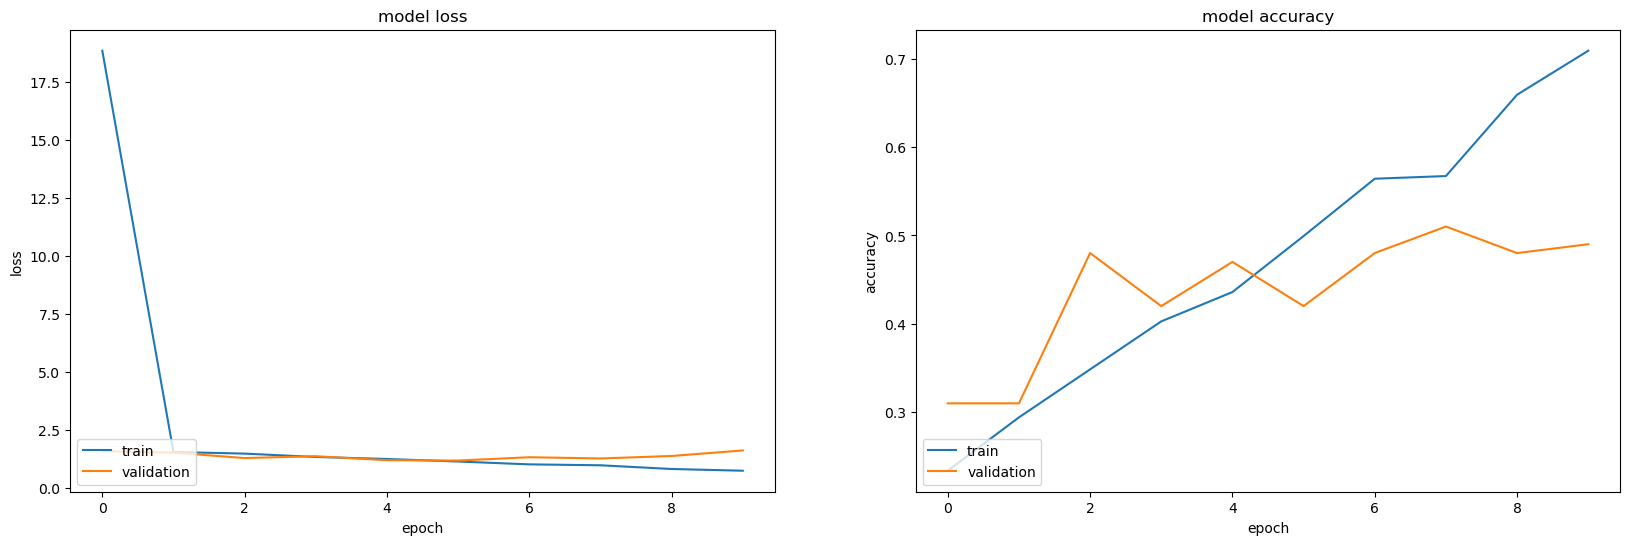

In [15]:

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history1.history['loss'])
ax1 = plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history1.history['categorical_accuracy'])
ax2 = plt.plot(history1.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

## Model2 with Conv3D, MaxPooling3D (Adding more layers) and BatchNormalization

In [14]:
#write your model here
Model2 = Sequential()
Model2.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
Model2.add(BatchNormalization())
Model2.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
Model2.add(BatchNormalization())
Model2.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
Model2.add(BatchNormalization())
Model2.add(TimeDistributed(
    Dense(64, activation='relu'))
)
Model2.add(BatchNormalization())
Model2.add(GlobalAveragePooling2D())
Model2.add(Dense(64, activation='relu'))
Model2.add(Dense(5, activation='softmax'))

# ###### Ram

# Model2 = Sequential()
# Model2.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# Model2.add(BatchNormalization())
# Model2.add(MaxPooling3D(pool_size=2))
# Model2.add(Dropout(0.25))

# Model2.add(Conv3D(64, kernel_size=3, activation='relu'))
# Model2.add(BatchNormalization())
# Model2.add(MaxPooling3D(pool_size=2))
# Model2.add(Dropout(0.25))

# Model2.add(Conv3D(128, kernel_size=3, activation='relu'))
# Model2.add(BatchNormalization())
# Model2.add(MaxPooling3D(pool_size=2))
# Model2.add(Dropout(0.25))

# # Model2.add(Conv3D(256, kernel_size=3, activation='relu'))
# # Model2.add(BatchNormalization())
# # Model2.add(MaxPooling3D(pool_size=2))
# # Model2.add(Dropout(0.25))

# Model2.add(Flatten())
# Model2.add(Dropout(0.25))

# Model2.add(Dense(256, activation='relu'))
# Model2.add(BatchNormalization())

# Model2.add(Dense(5, activation='softmax'))
# ###### Ram


optimiser = optimizers.Adam(learning_rate=0.01)

Model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (Model2.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5' + '.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

    
history2 = Model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

C:\Users\mathu\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 15, 62, 62, 8)       │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 15, 62, 62, 8)       │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 15, 60, 60, 16)      │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 15, 60, 60, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d (ConvLSTM2D)             │ (None, 58, 58, 8)           │           6,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 58, 58, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 58, 58, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 58, 58, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,781 (53.83 KB)

 Trainable params: 13,589 (53.08 KB)

 Non-trainable params: 192 (768.00 B)

C:\Users\mathu\AppData\Local\Temp\ipykernel_21448\4246969279.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*processing_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


None
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3618 - loss: 1.4121
Epoch 1: saving model to model_init_2024-12-2613_30_00.318869/model-00001-1.26971-0.44042-1.74515-0.22000.h5.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - categorical_accuracy: 0.3650 - loss: 1.4062 - val_categorical_accuracy: 0.2200 - val_loss: 1.7452 - learning_rate: 0.0100
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5980 - loss: 0.9702
Epoch 2: saving model to model_init_2024-12-2613_30_00.318869/model-00002-0.96819-0.58069-1.92252-0.25000.h5.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - categorical_accuracy: 0.5973 - loss: 0.9701 - val_categorical_accuracy: 0.2500 - val_loss: 1.9225 - learning_rate: 0.0100
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6370 - loss: 0.7945
Epoch 3: saving model to model_init_2024-12-2613_30_00.318869/model-00003-0.84292-0.62443-2.05873-0.28000.h5.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step 

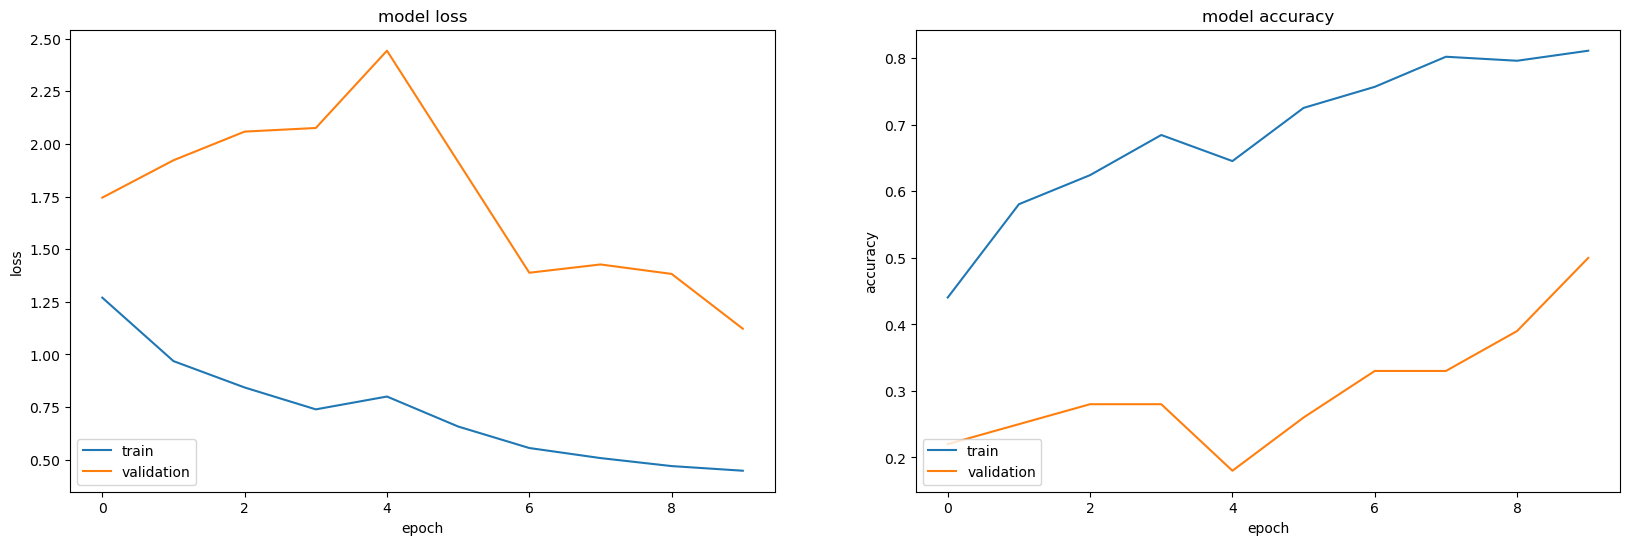

In [16]:

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history2.history['loss'])
ax1 = plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history2.history['categorical_accuracy'])
ax2 = plt.plot(history2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

In [19]:
input_shape

(15, 64, 64, 3)

## Model3 with Conv3D, MaxPooling3D (Adding more layers), BatchNormalization and LSTM

In [18]:
Model3 = Sequential()
Model3.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
Model3.add(BatchNormalization())
Model3.add(MaxPooling3D(pool_size=2))
Model3.add(Dropout(0.25))

Model3.add(Conv3D(64, kernel_size=3, activation='relu'))
Model3.add(BatchNormalization())
Model3.add(MaxPooling3D(pool_size=2))
Model3.add(Dropout(0.25))

# Model3.add(Conv3D(128, kernel_size=3, activation='relu'))
# Model3.add(BatchNormalization())
# Model3.add(MaxPooling3D(pool_size=2))
# Model3.add(Dropout(0.25))

# Model2.add(Conv3D(256, kernel_size=3, activation='relu'))
# Model2.add(BatchNormalization())
# Model2.add(MaxPooling3D(pool_size=2))
# Model2.add(Dropout(0.25))

Model3.add(Flatten())
Model3.add(Dropout(0.25))

Model3.add(Dense(256, activation='relu'))
Model3.add(BatchNormalization())

Model3.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam(learning_rate=0.01)

Model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (Model3.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5' + '.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

    
history2 = Model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_5 (Conv3D)                    │ (None, 13, 62, 62, 32)      │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 13, 62, 62, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 6, 31, 31, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 6, 31, 31, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 4, 29, 29, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 4, 29, 29, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 2, 14, 14, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2, 14, 14, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,483,461 (24.73 MB)

 Trainable params: 6,482,757 (24.73 MB)

 Non-trainable params: 704 (2.75 KB)

None


C:\Users\mathu\AppData\Local\Temp\ipykernel_21448\4246969279.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*processing_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/10
16/23 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - categorical_accuracy: 0.4236 - loss: 2.0318

KeyboardInterrupt: 

In [ ]:

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history3.history['loss'])
ax1 = plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history3.history['categorical_accuracy'])
ax2 = plt.plot(history3.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

## Model4 with Conv3D, MaxPooling3D (Adding more layers), BatchNormalization and LSTM

In [ ]:
Model3 = Sequential()
Model3.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape)))
Model3.add(TimeDistributed(BatchNormalization()))
Model3.add(MaxPooling3D(pool_size=2))
Model3.add(Dropout(0.25))

Model3.add(BatchNormalization())

Model3.add(ConvLSTM2D(8, kernel_size=3, return_sequences=False))
Model3.add(TimeDistributed(BatchNormalization()))
Model3.add(MaxPooling3D(pool_size=2))
Model3.add(Dropout(0.25))

Model3.add(TimeDistributed(Conv2D(128, kernel_size=3, activation='relu')))
Model3.add(BatchNormalization())
Model3.add(MaxPooling3D(pool_size=2))
Model3.add(Dropout(0.25))

# Model3.add(TimeDistributed(Conv2D(256, kernel_size=3, activation='relu')))
# Model3.add(BatchNormalization())
# Model3.add(MaxPooling3D(pool_size=2))
# Model3.add(Dropout(0.25))


Model3.add(Flatten())
Model3.add(Dropout(0.25))

Model3.add(Dense(256, activation='relu'))
Model3.add(BatchNormalization())

Model3.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam(learning_rate=0.01)

Model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5' + '.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

    
history3 = Model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

In [ ]:
# #TEMP

# Model3 = Sequential()
# Model3.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape)))
# Model3.add(TimeDistributed(BatchNormalization()))
# Model3.add(TimeDistributed(MaxPooling3D(pool_size=2)))
# #Model3.add(Dropout(0.25))

# Model3.add(TimeDistributed(Conv2D(64, kernel_size=3, activation='relu')))
# Model3.add(TimeDistributed(BatchNormalization()))
# Model3.add(TimeDistributed(MaxPooling3D(pool_size=2)))
# #Model3.add(Dropout(0.25))

# Model3.add(TimeDistributed(Conv2D(128, kernel_size=3, activation='relu')))
# Model3.add(TimeDistributed(BatchNormalization()))
# Model3.add(TimeDistributed(MaxPooling3D(pool_size=2)))
# #Model3.add(Dropout(0.25))

# Model3.add(Flatten())
# Model3.add(Dropout(0.25))

# Model3.add(Dense(256, activation='relu'))
# Model3.add(BatchNormalization())

# Model3.add(Dense(5, activation='softmax'))


# optimiser = optimizers.Adam(learning_rate=0.01)

# Model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

# train_generator = generator(train_path, train_doc, batch_size)
# val_generator = generator(val_path, val_doc, batch_size)


# model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
# if not os.path.exists(model_name):
#     os.mkdir(model_name)
        
# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5' + '.keras'

# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
# #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]


# if (num_train_sequences%batch_size) == 0:
#     steps_per_epoch = int(num_train_sequences/batch_size)
# else:
#     steps_per_epoch = (num_train_sequences//batch_size) + 1

# if (num_val_sequences%batch_size) == 0:
#     validation_steps = int(num_val_sequences/batch_size)
# else:
#     validation_steps = (num_val_sequences//batch_size) + 1
    

    
# history2 = Model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

In [ ]:
##### Model 3 TEMP
Model3 = Sequential()
Model3.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
Model3.add(BatchNormalization())
Model3.add(MaxPooling3D(pool_size=2))
Model3.add(Dropout(0.25))

Model3.add(Conv3D(64, kernel_size=3, activation='relu'))
Model3.add(BatchNormalization())
Model3.add(MaxPooling3D(pool_size=2))
Model3.add(Dropout(0.25))

Model3.add(Conv3D(128, kernel_size=3, activation='relu'))
Model3.add(BatchNormalization())
Model3.add(MaxPooling3D(pool_size=2))
Model3.add(Dropout(0.25))

# Model3.add(Conv3D(256, kernel_size=3, activation='relu'))
# Model3.add(BatchNormalization())
# Model3.add(MaxPooling3D(pool_size=2))
# Model3.add(Dropout(0.25))

Model3.add(Flatten())
Model3.add(Dropout(0.25))

Model3.add(Dense(256, activation='relu'))


Model3.add(BatchNormalization())

Model3.add(Dense(5, activation='softmax'))












# #####Ram

# Model3 = Sequential()
# Model3.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape)))
# Model3.add(TimeDistributed(BatchNormalization()))
# Model3.add(MaxPooling3D(pool_size=2))
# Model3.add(Dropout(0.25))

# Model3.add(TimeDistributed(Conv2D(64, kernel_size=3, activation='relu')))
# Model3.add(TimeDistributed(BatchNormalization()))
# Model3.add(MaxPooling3D(pool_size=2))
# Model3.add(Dropout(0.25))

# Model3.add(TimeDistributed(Conv2D(128, kernel_size=3, activation='relu')))
# Model3.add(BatchNormalization())
# Model3.add(MaxPooling3D(pool_size=2))
# Model3.add(Dropout(0.25))
# Model3.add(Flatten())
# Model3.add(Dropout(0.25))

# Model3.add(Dense(256, activation='relu'))
# Model3.add(BatchNormalization())

# Model3.add(Dense(5, activation='softmax'))

# #####Ram
# Model3.add(TimeDistributed(Conv2D(256, kernel_size=3, activation='relu')))
# Model3.add(BatchNormalization())
# Model3.add(MaxPooling3D(pool_size=2))
# Model3.add(Dropout(0.25))




optimiser = optimizers.Adam(learning_rate=0.01)

Model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (Model3.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5' + '.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

    
history3 = Model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)